In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(int(time.time()))

In [2]:
class NeuronLayer:
    def __init__(self, prevCount, struct):
        self.prevCount = prevCount
        self.count = struct['neurons']
        self.neurons = None
        self.errors = np.zeros((self.count, 1))
        self.activationDerivative = lambda A: A
        self.alpha = 0.25
        if(struct['type'] != 'input'):
            self.synapses = np.random.rand(self.count, self.prevCount)*2-1
            self.bias = np.ones((self.count, 1))
            self.learningRate = struct['learningRate']
            self.dropoutRate = struct['dropoutRate']
            self.dropout = np.array([[self.learningRate]*prevCount]*self.count)
            if (struct['activation'] == 'identity'):
                self.activation = lambda A: self.identity(A)
                self.activationDerivative = lambda A: self.identity_derivative(A)
            elif (struct['activation'] == 'binarystep'):
                self.activation = lambda A: self.binarystep(A)
                self.activationDerivative = lambda A: self.binarystep_derivative(A)
            elif (struct['activation'] == 'sigmoid'):
                self.activation = lambda A: self.sigmoid(A)
                self.activationDerivative = lambda A: self.sigmoid_derivative(A)
            elif (struct['activation'] == 'tanh'):
                self.activation = lambda A: self.tanh(A)
                self.activationDerivative = lambda A: self.tanh_derivative(A)
            elif (struct['activation'] == 'arctan'):
                self.activation = lambda A: self.arctan(A)
                self.activationDerivative = lambda A: self.arctan_derivative(A)
            elif (struct['activation'] == 'ReLU'):
                self.activation = lambda A: self.ReLU(A)
                self.activationDerivative = lambda A: self.ReLU_derivative(A)
            elif (struct['activation'] == 'leakyReLU'):
                self.activation = lambda A: self.leakyReLU(A)
                self.activationDerivative = lambda A: self.leakyReLU_derivative(A)
            elif (struct['activation'] == 'ELU'):
                self.activation = lambda A: self.ELU(A)
                self.activationDerivative = lambda A: self.ELU_derivative(A)
            elif (struct['activation'] == 'softplus'):
                self.activation = lambda A: self.softplus(A)
                self.activationDerivative = lambda A: self.softplus_derivative(A)
            elif (struct['activation'] == 'softmax'):
                self.activation = lambda A: self.softmax(A)
                self.activationDerivative = lambda A: self.softmax_derivative(A)
            else:
                print('ERROR: NeuronLayer requires valid activation.')

    def identity(self, A):
        return A
    
    def identity_derivative(self, A):
        return np.ones(A.shape)
    
    def binarystep(self, A):
        return np.where(A < 0, 0, 1)
    
    def binarystep_derivative(self, A):
        return np.ones(A.shape)

    def sigmoid(self, A):
        return 1 / (1 + np.exp(-A))

    def sigmoid_derivative(self, A):
        return A * (1 - A)

    def tanh(self, A):
        return np.tanh(A)
    
    def tanh_derivative(self, A):
        return 1 - np.power(np.tanh(A), 2)

    def arctan(self, A):
        return np.arctan(A)
    
    def arctan_derivative(self, A):
        return 1 / (np.power(A, 2) + 1)

    def ReLU(self, A):
        return np.where(A >= 0, A, 0)

    def ReLU_derivative(self, A):
        return np.where(A >= 0, 1, 0)

    def leakyReLU(self, A):
        return np.where(A >= 0, A, np.multiply(self.alpha,A))

    def leakyReLU_derivative(self, A):
        return np.where(A >= 0, 1, self.alpha)

    def ELU(self, A):
        return np.where(A >= 0, A, np.multiply(self.alpha, np.exp(A)-1))

    def ELU_derivative(self, A):
        return np.where(A >= 0, 1, np.multiply(
            self.alpha, np.exp(A)-1) + self.alpha)

    def softplus(self, A):
        return np.log(1 + np.exp(A))

    def softplus_derivative(self, A):
        return 1 / (1 + np.exp(-A))
    
    def softmax(self, A):
        e = np.exp(A - np.max(A))
        return e / e.sum()
    
    def softmax_derivative(self, A):
        return A

    def dropoutUpdate(self, level=0):
        if (level == 0):
            if (self.dropoutRate != 0):
                self.dropout = self.learningRate * np.random.choice([0, 1],
                    size=(self.count, self.prevCount),
                    p=[self.dropoutRate, 1-self.dropoutRate]).astype(np.bool)
        elif(level == 1):
            np.random.shuffle(self.dropout)

In [3]:
class NeuralNetwork:
    def __init__(self, networkStruct):
        self.network = list()
        self.accHistory = list()
        self.layers = len(networkStruct)
        self.network.append(NeuronLayer(0, networkStruct[0]))
        self.confusionMatrix = None
        for i in range(1, self.layers):
            self.network.append(NeuronLayer(networkStruct[i-1]['neurons'], 
                                            networkStruct[i]))

    def feedForward(self, data, target=None, batchSize=1):
        self.network[0].neurons = data
        for i in range(1, self.layers):
            wx = np.dot(self.network[i].synapses,
                    self.network[i-1].neurons).T
            wx = wx.reshape(batchSize, self.network[i].count, 1)
            self.network[i].neurons = self.network[i].activation(
                 wx + self.network[i].bias)
        if (type(target) != type(None)):
            self.network[-1].errors += np.average(
                (target-self.network[-1].neurons) * \
                    self.network[-1].activationDerivative(
                        self.network[-1].neurons), axis=0)

    def backpropagation(self):
        for i in reversed(range(1, self.layers)):
            self.network[i-1].neurons = np.average(
                self.network[i-1].neurons, axis=0)
            self.network[i].synapses += self.network[i].dropout * \
                np.dot(self.network[i].errors,
                    self.network[i-1].neurons.T)
            self.network[i].bias -= np.multiply(
                self.network[i].learningRate,
                self.network[i].errors)
            self.network[i-1].errors = np.multiply(np.dot(
                self.network[i].synapses.T,
                self.network[i].errors
            ),  self.network[i-1].activationDerivative(self.network[i-1].neurons))
        self.network[-1].errors = 0

    def train(self, trainLabels, trainData, epochs=1, 
              testLabels=[], testData=[], batchSize=1):
        zippedData = list(zip(trainLabels,trainData))
        for i in range(epochs):
            print('\t-- Epoch {}'.format(i+1))
            for j in range(1, self.layers):
                self.network[j].dropoutUpdate(0)
            np.random.shuffle(zippedData)
            k = 0
            while (k < len(zippedData)):
                label, data = list(zip(*zippedData[k:k+batchSize]))
                label, data = np.array(label), np.array([np.array(data).T]).T
                target = self.oneHotEncode(label)
                self.feedForward(data, target, batchSize)
                self.backpropagation()
                k += batchSize
            self.test(testLabels, testData)
            accuracy = np.sum(self.confusionMatrix.diagonal()) / \
                       np.sum(self.confusionMatrix)
            self.accHistory.append(accuracy)
            print('Accuracy = {0:.2f}%'.format(accuracy*100))
        plt.plot(np.arange(epochs), self.accHistory)
        plt.title("Training Output History")
        plt.xlabel("Epoch")
        plt.xlabel("Accuracy")
        plt.yticks(np.arange(0, 1.1, step=0.1))

    def test(self, labels, testData):
        self.confusionMatrix = np.zeros((
            self.network[-1].count, self.network[-1].count))
        for i, (label, data) in enumerate(zip(labels, testData)):
            self.feedForward(data)
            bestIndex = np.argmax(self.network[-1].neurons)
            self.confusionMatrix[label, bestIndex] += 1
    
    def miniBatch(self, data, batchSize=100):
        i = 0
        while (i < len(data)):
            i += batchSize

    def predict(self, data):
        self.feedForward(data)
        return np.argmax(self.network[-1].neurons)
            
    def oneHotEncode(self, index):
        index = np.array(index, dtype=np.int)
        if(type(index) == int):
            vect = np.zeros((self.network[-1].count, 1))
            vect[index][0] = 1
        else:
            vect = np.zeros((len(index),self.network[-1].count, 1))
            vect[range(len(index)), index, 0] = 1
        return vect
    
    def logLikelihood(self, y, yhat):
        return np.where((y/2)-0.5+yhat > 0, -np.log(np.abs((y/2)-0.5+yhat)), 0)
    
    def entropy(p):
        return -np.sum(p*np.log2(p))
        
    def crossEntropy(self, p, q):
        '''
        p = true probability distribution (expected)
        q = predicted probability distribution (guessed)
        '''
        return -np.sum(np.where(q > 0, p*np.log2(q), 0))

    def KLDivergence(self, p, q):
        return self.crossEntropy(p,q) - self.entropy(p)
        

In [4]:
class DataLoader:
    def __init__(self):
        pass

    def standardize(self, A):
        return (A - np.mean(A)) / np.std(A)

    def normalize(self, A):
        return (A - np.min(A)) / (np.max(A) - np.min(A))

    def extractMNIST(self, fileName):
        labels = []
        fname = open(fileName, "r")
        values = fname.readlines()[:20000]
        fname.close()
        for i, record in enumerate(values):
            data = record.split(",")
            values[i] = np.asfarray(data[1:]) / 255
            labels.append(int(data[0]))
        return labels, values

Creating Network
Opening Training Data
Opening Testing Data
Training:
	-- Epoch 1
Accuracy = 30.83%
	-- Epoch 2
Accuracy = 43.58%
	-- Epoch 3
Accuracy = 56.28%
	-- Epoch 4
Accuracy = 63.23%
	-- Epoch 5
Accuracy = 69.02%
	-- Epoch 6
Accuracy = 74.33%
	-- Epoch 7
Accuracy = 77.63%
	-- Epoch 8
Accuracy = 79.12%
	-- Epoch 9
Accuracy = 80.54%
	-- Epoch 10
Accuracy = 81.26%
	-- Epoch 11
Accuracy = 82.35%
	-- Epoch 12
Accuracy = 83.07%
	-- Epoch 13
Accuracy = 83.51%
	-- Epoch 14
Accuracy = 84.01%
	-- Epoch 15
Accuracy = 84.17%
	-- Epoch 16
Accuracy = 84.79%
	-- Epoch 17
Accuracy = 84.83%
	-- Epoch 18
Accuracy = 84.93%
	-- Epoch 19
Accuracy = 85.25%
	-- Epoch 20
Accuracy = 85.45%
	-- Epoch 21
Accuracy = 85.85%
	-- Epoch 22
Accuracy = 85.80%
	-- Epoch 23
Accuracy = 85.87%
	-- Epoch 24
Accuracy = 85.64%
	-- Epoch 25
Accuracy = 86.14%
	-- Epoch 26
Accuracy = 86.24%
	-- Epoch 27
Accuracy = 85.86%
	-- Epoch 28
Accuracy = 86.17%
	-- Epoch 29
Accuracy = 86.01%
	-- Epoch 30
Accuracy = 85.95%
Input : 7

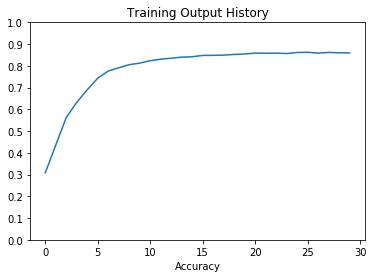

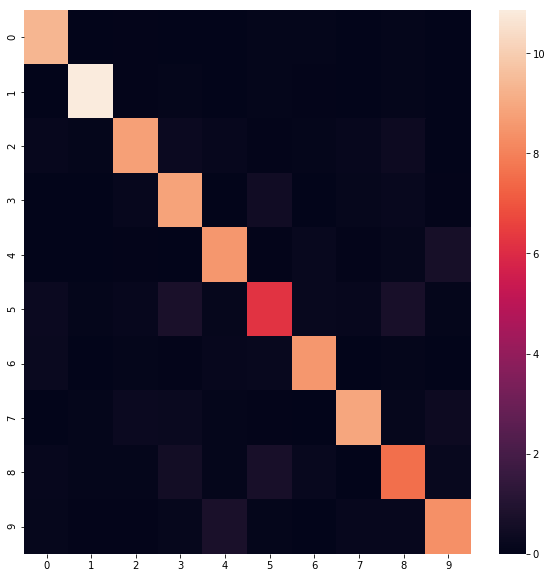

In [6]:
import pandas as pd
import seaborn as sn
# Design neural network
network = {0:  
           {'neurons':     784,
            'type':       'input'},
           1:  
           {'neurons':     250,
            'learningRate': 0.001,
            'activation': 'tanh',
            'dropoutRate': 0.01,
            'type':       'hidden'},
           2:  
#            {'neurons':     150,
#             'learningRate': 0.001,
#             'activation': 'tanh',
#             'dropoutRate': 0.01,
#             'type':       'hidden'},
#            3:  
           {'neurons':     10,
            'learningRate': 0.001,
            'activation': 'softmax',
            'dropoutRate': 0.01,
            'type':       'output'}}

# Input parameters
epochs = 30
suppressOutput = False

# Create neural network
print("Creating Network")
ann = NeuralNetwork(network)

# Open files with DataLoader class methods specific for MNIST data.
dl = DataLoader()
print("Opening Training Data")
MNIST_Train_Labels, MNIST_Train_Values = dl.extractMNIST("MNIST/mnist_train.csv")
print("Opening Testing Data")
MNIST_Test_Labels, MNIST_Test_Values = dl.extractMNIST("MNIST/mnist_test.csv")

# Train
print("Training:")
ann.train(MNIST_Train_Labels, MNIST_Train_Values, epochs,
          MNIST_Test_Labels, MNIST_Test_Values, 1)

# Predict 
pred = ann.predict(MNIST_Test_Values[0])
print("Input : {}".format(MNIST_Test_Labels[0]))
print("Output: {}".format(pred))
df = pd.DataFrame(ann.confusionMatrix / np.sum(ann.confusionMatrix) * 100)
plt.figure(figsize=(10,10))
sn.heatmap(df)